In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


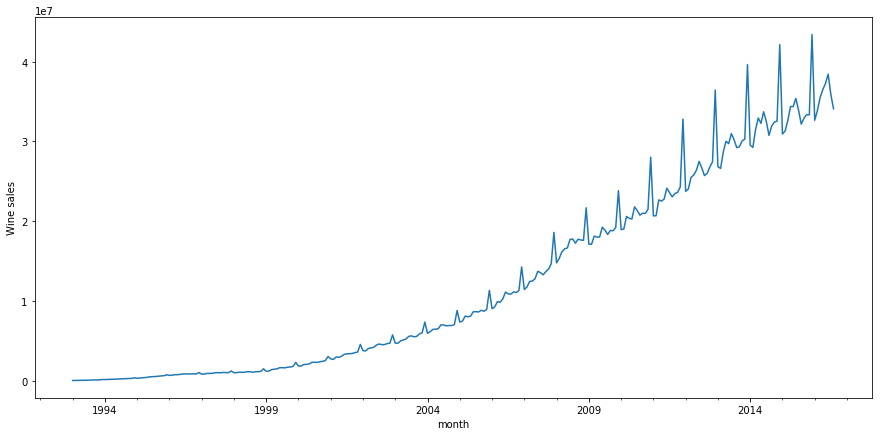

In [3]:
wag_c_m = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wag_c_m.sales = wag_c_m.WAG_C_M * 1000
plt.figure(figsize(15,7))
wag_c_m.sales.plot()
plt.ylabel('Wine sales')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

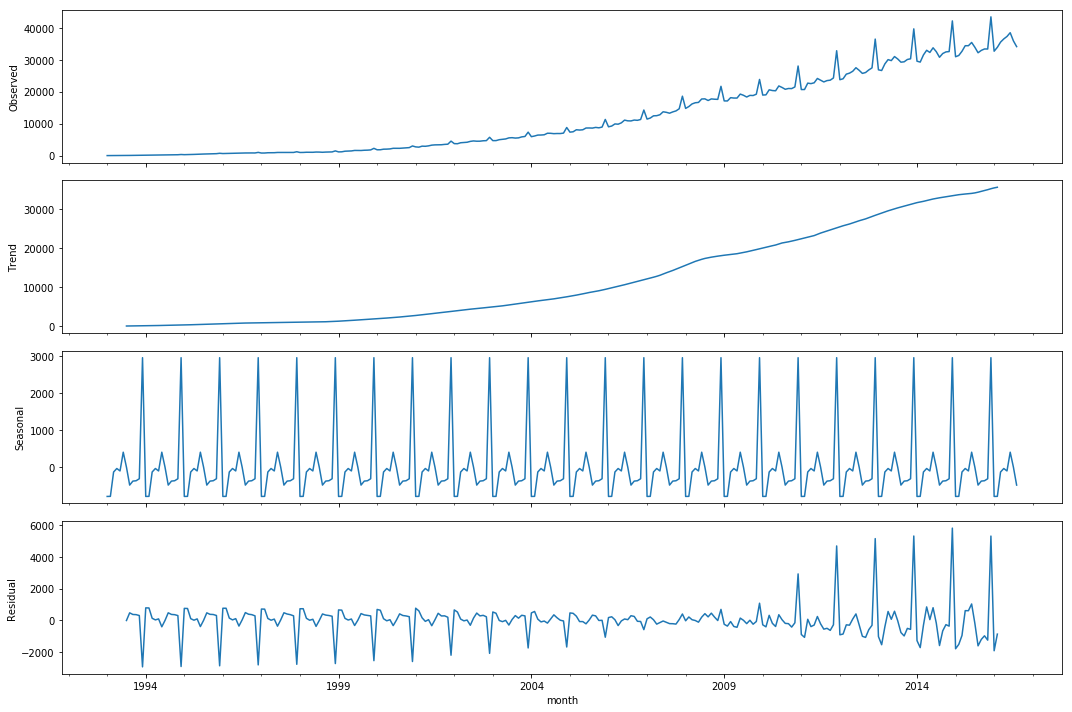

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag_c_m.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m.WAG_C_M)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


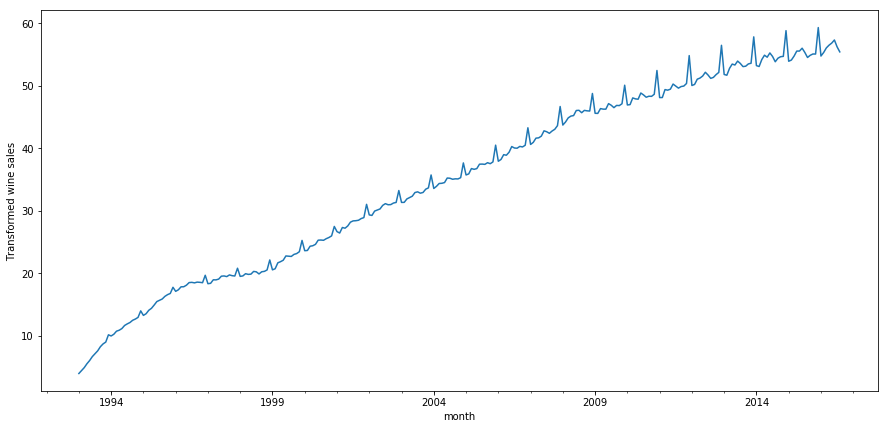

In [5]:
wag_c_m['wag_box'], lmbda = stats.boxcox(wag_c_m.WAG_C_M)
plt.figure(figsize(15,7))
wag_c_m.wag_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m.wag_box)[1])

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

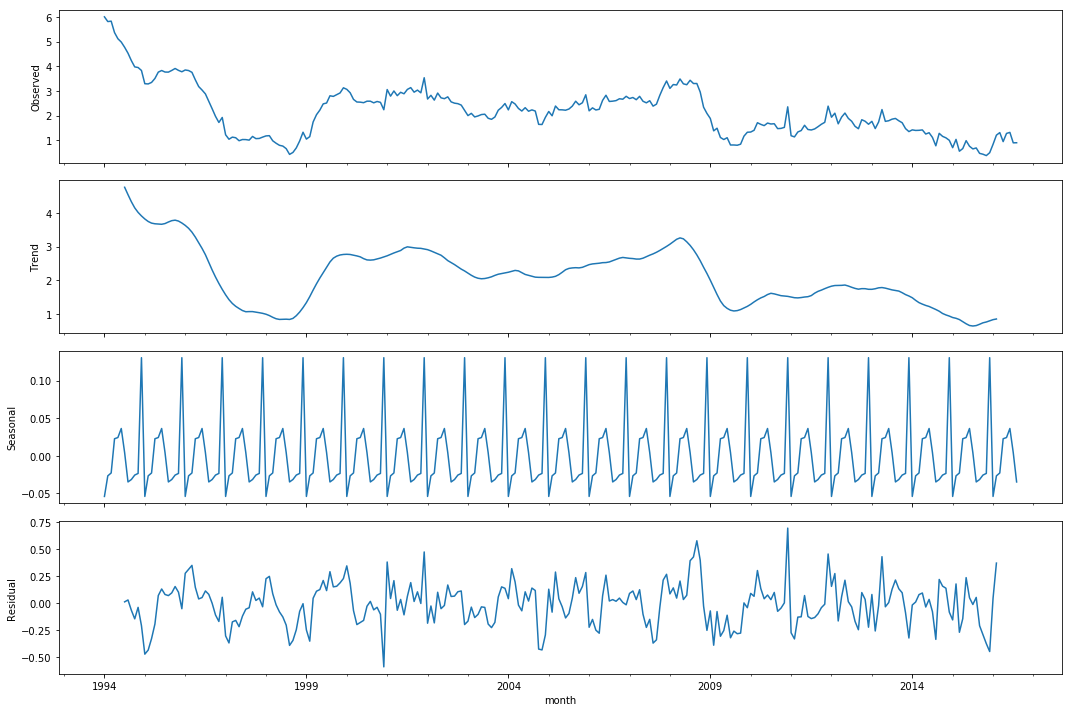

In [6]:
wag_c_m['wag_box_diff'] = wag_c_m.wag_box - wag_c_m.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag_c_m.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m.wag_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

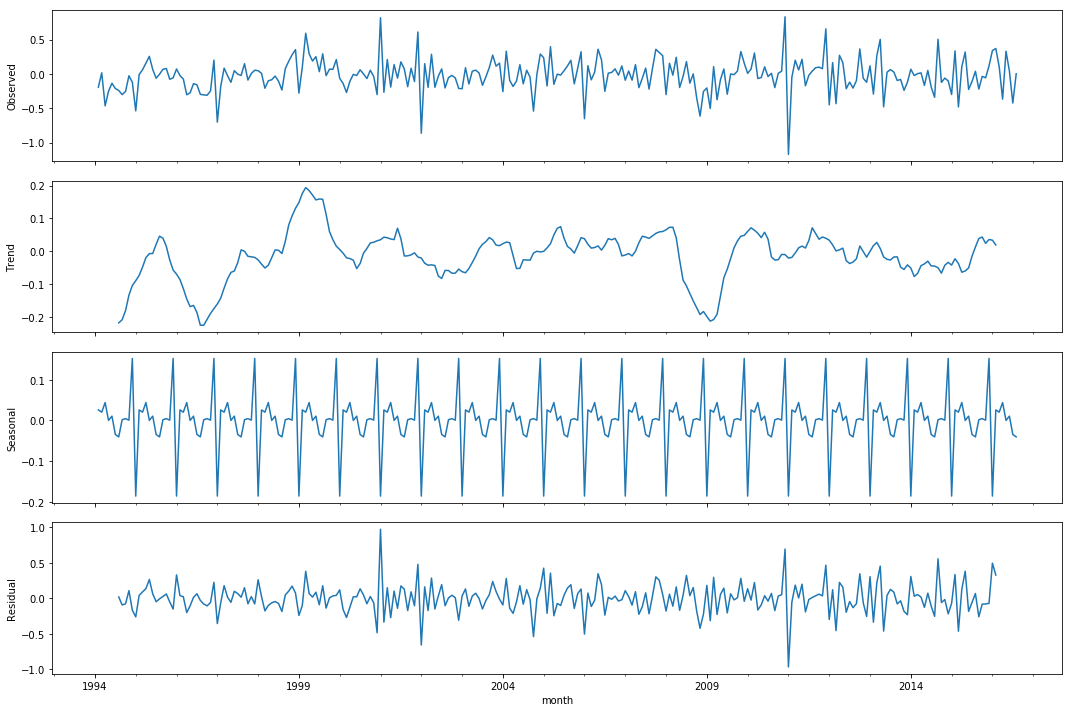

In [24]:
wag_c_m['wag_box_diff2'] = wag_c_m.wag_box_diff - wag_c_m.wag_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag_c_m.wag_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m.wag_box_diff2[13:])[1])

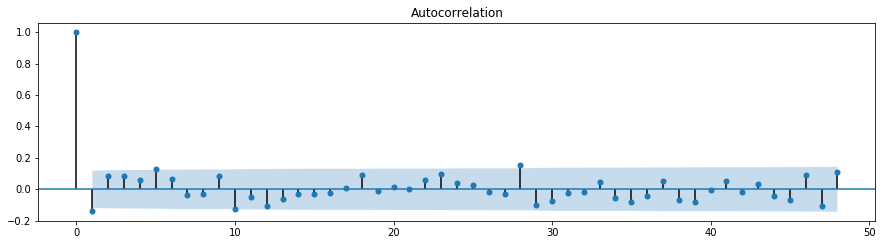

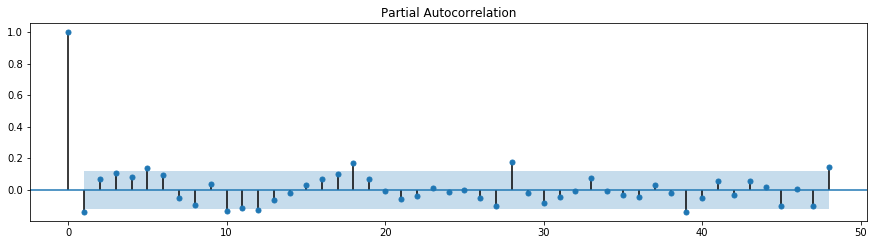

In [25]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag_c_m.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag_c_m.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [34]:
ps = range(0, 5)
d=1
qs = range(0, 7)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [35]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

70

In [36]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(wag_c_m.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
Wall time: 1min 30s


In [37]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
55  (4, 5, 1, 0) -23.992869
57  (4, 6, 1, 0) -23.933517
28  (2, 3, 0, 0) -21.091420
47  (3, 6, 1, 0) -20.895632
29  (2, 3, 1, 0) -20.398611


In [30]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(4, 1, 6)x(1, 1, 1, 12)   Log Likelihood                  25.012
Date:                            Thu, 18 Apr 2019   AIC                            -24.025
Time:                                    12:01:21   BIC                             22.803
Sample:                                01-01-1993   HQIC                            -5.223
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6597      0.214      3.078      0.002       0.240       1.080
ar.L2         -0.4186      0.071   

Критерий Стьюдента: p=0.212128
Критерий Дики-Фуллера: p=0.000000


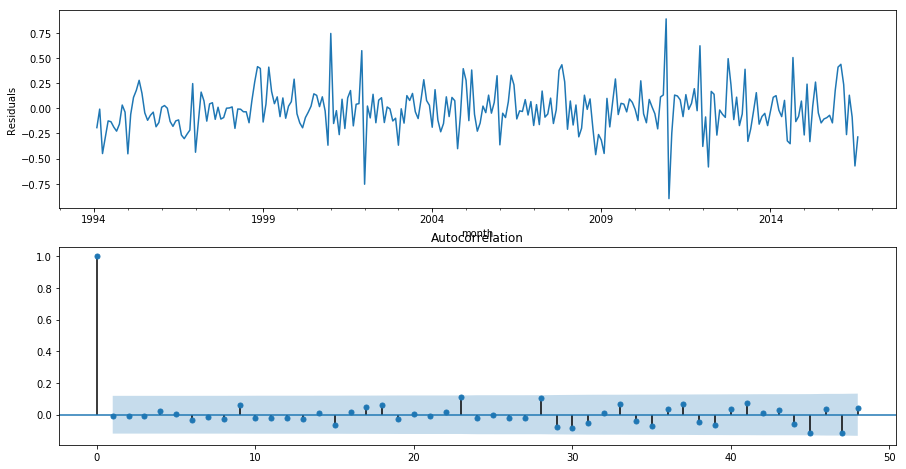

In [31]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

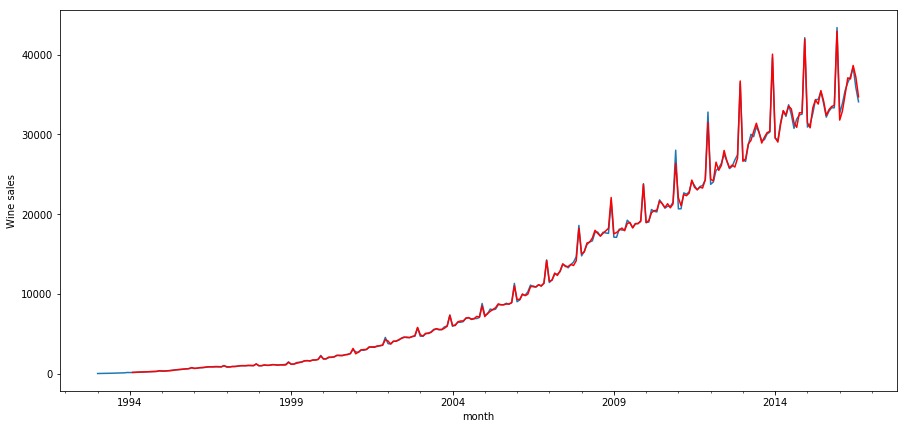

In [32]:
wag_c_m['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag_c_m.WAG_C_M.plot()
wag_c_m.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

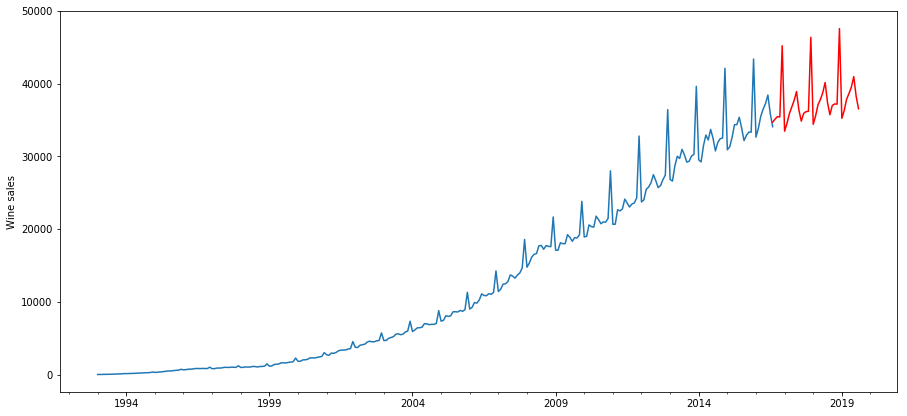

In [33]:
wag_c_m_predict = wag_c_m[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wag_c_m_predict.columns)
wag_c_m_predict = pd.concat([wag_c_m_predict, future])
wag_c_m_predict['forecast'] = invboxcox(best_model.predict(start=283, end=360), lmbda)

plt.figure(figsize(15,7))
wag_c_m_predict.WAG_C_M.plot()
wag_c_m_predict.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()